Uses code blocks from Pleth Analysis Single Run notebook to batch run everything within a folder

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy import signal, optimize
import peakutils
from peakutils.plot import plot as pplot
from pyentrp import entropy as ent

Put All File Names in a List

In [2]:
#This would be the line for bash access. but since we're using windows we have to do a long annoying workaround
#    filelst = !ls C:\Users\John\Dropbox\Exported\*.txt

In [3]:
filelst_process = !dir C:\Users\John\Dropbox\Exported\*.txt

In [4]:
filelst = []

for i in filelst_process.fields()[5:-2]: #start after header rows, and don't include the last two rows
    filelst.append(i[-1]) #take only the last object, which is the file name

In [5]:
filelst

['10-17-17-2_st2_lps-2.txt',
 '10-17-17-2_st2_lps-baseline.txt',
 '10-17-17-2_st2_lps-hypoxia.txt',
 '10-17-17-2_st2_lps-recovery.txt',
 '10-17-17-2_st2_lps.txt',
 '10-17-17-2_st2_sham-baseline.txt',
 '10-17-17-2_st2_sham-hypoxia.txt',
 '10-17-17-2_st2_sham-recovery.txt',
 '10-18-17-2-ST2_LPS-baseline.txt',
 '10-18-17-2-ST2_LPS-hypoxia.txt',
 '10-18-17-2-ST2_LPS-recovery.txt',
 '10-18-17-2-ST2_SHAM-baseline.txt',
 '10-18-17-7_ST2_SHAM-baseline.txt',
 '10-18-17-7_ST2_SHAM-hypoxia.txt',
 '10-18-17-7_ST2_SHAM-recovery.txt',
 '10-18-17_6_st2_lps-baseline.txt',
 '10-18-17_6_st2_lps-hypoxia.txt',
 '10-18-17_6_st2_lps-recovery.txt',
 '10-19-17-10-_MYD88_LPS-baseline.txt',
 '10-19-17-10-_MYD88_LPS-hypoxia.txt',
 '10-19-17-10-_MYD88_LPS-recovery.txt',
 '10-19-17-11_MYD88_LPS-baseline.txt',
 '10-19-17-11_MYD88_LPS-hypoxia.txt',
 '10-19-17-11_MYD88_LPS-recovery.txt',
 '10-19-17-12_MYD88_LPS-baseline.txt',
 '10-19-17-12_MYD88_LPS-hypoxia.txt',
 '10-19-17-12_MYD88_LPS-recovery.txt',
 '10-19-17-9_MY

Non-integratable Functions

In [6]:
def burstcalc(dataframe, thresh, clustertime=0, burstmin = 0, burstmax=100000):
    
    time = dataframe.index
    data = dataframe.values
    
    burst_start = [] #empty array for burst start
    burst_end = [] #empty array for burst end
    burst_duration = [] #empty array to calculate burst durration
    
    thresh *= np.max(data) - np.min(data)
    #normalized threshold between 0 and 1
    
    burst = False #burst flag, should start not in a burst

    index = -1
    for point in data: #for each data point in the set
        index = index +1
        #print index, "=", t.clock()
        
        if burst == False and point > thresh: #if we are not in a burst already, the value is higher than the threshold, 
            #   AND the last burst didn't end less than .2 ms ago
            #   .2 ms WHERE???? maybe from rat_ECG.txt test data file?
            tpoint = time[index] #find the actual time given the time index
            burst_start.append(tpoint) #add the time at point as the begining of the burst
            burst = True #burst flag, we are now in a burst 
        
        if burst == True and  point <= thresh: #if we are in a burst and the point falls below the threshold
            
            if len(burst_end) == 0 or len(burst_start) == 0: #if this is the first end
                tpoint = time[index] #find the actual time given teh time index
                burst_end.append (tpoint) #add the time at point as the end of the burst
                burst = False #burst flag, we are now out of the burst
            
            else:
                tpoint = time[index] #find the actual time given teh time index
                burst_end.append (tpoint) #add the time at point as the end of the burst
                burst = False #burst flag, we are now out of the burst
                if burst_start[-1] < (burst_end[-2] + clustertime):#if the new burst is too close to the last one, delete the second to last end and the last start
                    del burst_end[-2]
                    del burst_start[-1]
    
    if burst == True and len(burst_start) == 1+len(burst_end): #we exit the for loop but are in a burst
        #del burst_start[-1] #delete the last burst start time
        burst_end.append(time[-1]) #last time point is the end of burst
    if len(burst_start) != len(burst_end):
        raise Exception('Unexpectedly, the number of burst start times and end times are not equal. Seeing as this is physically impossible, I quit the program for you. Begin hunting for the fatal flaw. Good luck!')
        
    #print t.clock(), "- start duration array"
    for foo in burst_start: #for each burst
        index = burst_start.index(foo)
        duration = burst_end[index] - burst_start[index] #calculate duration by subtracting the start time from the end time, found by indexing
        burst_duration.append(duration) #add the burst duration to the duration list
    #print t.clock(), "-end duration array"
    
    #return burst_start, burst_end, burst_duration
    
    #Burst Calc into DataFrame
    results_bursts = pd.DataFrame({'Burst Start': burst_start})
    results_bursts.index = np.arange(len(burst_start))
    results_bursts['Burst End'] = burst_end
    results_bursts['Burst Duration'] = burst_duration
    
    results_bursts = results_bursts[results_bursts['Burst Duration']>burstmin]
    results_bursts = results_bursts[results_bursts['Burst Duration']<=burstmax]
    
    return results_bursts #dataframe

In [7]:
def burstarea(dataframe, results_bursts, dx = 1):
    
    data = dataframe.values
    time = dataframe.index
    burst_start = results_bursts['Burst Start'].values
    burst_end = results_bursts['Burst End'].values
    
    """
    integral, area under curve of each burst. Use start and end times to split the y values into short lists. 
    need the time array to do this
    """
    from scipy.integrate import simps, trapz #import the integral functions
    
    time = list(time) #time array must be a list for the indexting to work.
    
    burst_area = [] #empty array for the areas to go into
    #count = 0
    for i in np.arange(len(burst_start)): #for each index in the start array
        end = time.index(burst_end[i]) #using the value at each i in the burst_end array, index in the time array to get the time index. this will be the same index # as the data array
        start = time.index(burst_start[i])
        area = trapz(data[start:end], x=time[start:end], dx= dx) #find area using the trapz function, but only 
        burst_area.append(area)
 
    return burst_area

In [8]:
def interburstinterval(burst_start, burst_end):
    
    ibi = []
    
    for i in np.arange(0, len(burst_start)-1):
        ibi.append(burst_start[i+1] - burst_end[i])
        
    return ibi

In [9]:
def poincare(array):
    #calculate SD1 and SD2
    #definitions obtained from http://www.if.uz.zgora.pl/~jaropis/geomasy.pdf, modified from bass code
    
    df = pd.DataFrame(array)
    data = df.dropna()
    data = data[0].values
    
    x = data[:-1]
    y = data[1:]
    
    xc = np.mean(x)
    yc = np.mean(y)  
    
    SD1 = 0
    SD2 = 0
    
    for i in np.arange(len(x)):
        
        d1 = np.power(abs((x[i]-xc)-(y[i]-yc))/np.sqrt(2), 2)
        SD1 = SD1 + d1
        
        d2 = np.power(abs((x[i]-xc)+(y[i]-yc))/np.sqrt(2), 2)
        SD2 = SD2 + d2
    
    SD1 = np.sqrt(SD1/len(x))
    SD2 = np.sqrt(SD2/len(x))
    
    return x, y, xc, yc, SD1, SD2 

def poincare_plot(data, label, filename):
    #function to plot
    x, y, xc, yc, SD1, SD2 = poincare(data)
    
    center = xc, yc
    
    ax = plt.subplot(111, aspect = "equal")
    
    plt.plot(center[0], center[1], color="r", marker= "+")

    y1 = x
    y2 = y
    
    ellipse = patches.Ellipse(center, width = SD2, height = SD1, angle = 45, fill = False, color = "r")

    ax.set_xlabel("y(t)")
    ax.set_ylabel("y(t + 1)")
    ax.scatter(y1, y2, color = 'k', marker = '.')
    ax.add_patch(ellipse)
    

    plt.title(filename + ' Poincare Plot ' + label)
    plt.savefig('Poincare_Plots\\' + filename + '_Poincare Plot_' + label + '.png', dpi=600) 
    
    plt.show()
    
    return SD1, SD2

In [10]:
%%time

#See Single Run Notebook for more details on functions
#Will fail if no folder named Poincare_Plots

#SG Settings
window = 31
polyorder = 6

#Peak Detect Settings
thresh = .4
min_dist = 90

#Burst Detect Settings
b_thresh = .3
clustertime = 0.05
burstmin = 0
burstmax = 100000

def run_and_analyze(filename):
    
    #Load File
    df = pd.read_csv('C:\Users\John\Dropbox\Exported\\' + filename, #make sure to change the path if using for your own purposes
                 sep = '\t', names = ["Time", "Data"], index_col='Time')
    
    #Detrend
    df['peakutils'] = peakutils.baseline(df['Data'], 6) #polynomial = 6, can change
    df['Detrend'] = df['Data']-df['peakutils']
    
    #SG Filter
    df['SG_Filter'] = signal.savgol_filter(df['Detrend'], window, polyorder)
    
    #Peak Detect
    indexes = peakutils.indexes(df['SG_Filter'].values, thresh, min_dist)
    
    #Burst Calculation
    results_bursts = burstcalc(df['SG_Filter'], b_thresh, clustertime, burstmin, burstmax)
    
    #Burst Area Calculation
    burst_area = burstarea(df['SG_Filter'], results_bursts, dx = 1)
    
    #
    #Results
    #
    
    Results = pd.DataFrame(index=[filename]) #initialize dataframe
    
    #Breaths
    # Calculated by counting the number of bursts
    Results['Breaths'] = results_bursts['Burst Start'].count()

    #Recording Length (s)
    # Last time index - first time index.
    Results['Recording Length (s)'] = df.index[-1]-df.index[0]

    #Mean Breath Rate (breaths per minute)
    # Breaths divided by minutes
    Results['Mean Breath Rate'] = Results['Breaths']/(Results['Recording Length (s)']/60)

    #Minute Ventilation
    # Average of all the peak amplitudes (tidal volume) * mean breath rate (respiratory rate)
    Results['Minute Ventilation'] = np.mean(df['SG_Filter'].values[indexes]) * Results['Mean Breath Rate']

    #AUC
    # Mean of Burst Area
    # Std Deviation of Burst Area
    Results['AUC Mean'] = np.nanmean(burst_area)
    Results['AUC Std'] = np.nanstd(burst_area)

    #Insp Time
    # Mean of Burst Duration
    # Std Deviation of Burst Duration
    bd = results_bursts['Burst Duration'].dropna()
    bd = bd.values
    Results['Insp Time Mean'] = np.nanmean(bd)
    Results['Insp Time Std'] = np.nanstd(bd)

    #Exp Time
    # Mean of Interburst Intervals
    # Std Deviation of Interburst Intervals
    ibi = interburstinterval(results_bursts['Burst Start'].values, results_bursts['Burst End'].values)
    ibi = np.asarray(ibi)
    Results['Exp Time Mean'] = np.nanmean(ibi)
    Results['Exp Time Std'] = np.nanstd(ibi)

    #TTotal Time
    # Mean of Total Cycle Time
    # Std Deviation of Total Cycle Time
    tct = np.diff(results_bursts['Burst Start'])
    Results['TTotal Mean'] = np.nanmean(tct)
    Results['TTotal Std'] = np.nanstd(tct)

    #Apnea Count
    # Calculate Apnea Threshold
    #    Set Apnea Index as the Mean Difference of Total Cycle times
    #    Definition of Apnea: 3 * the Apnea Index
    # Count Apneas
    #    If length of time between Burst Starts is > Apnea Threshold, add a count
    apnea_index = np.nanmean(tct)
    apnea_thresh = 3 * apnea_index
    apnea_count = list((tct > apnea_thresh)).count(True)

    #Sample Entropy
    # https://github.com/nikdon/pyEntropy
    # TI = Burst Duration
    # TE = IBI
    # TTotal = Total Cycle Time


    Results['SampEn TI'] = ent.sample_entropy(bd, 2, 0.2*np.std(bd))[0]
    Results['SampEn TE'] = ent.sample_entropy(ibi, 2, 0.2*np.std(ibi))[0]
    Results['SampEn TTotal'] = ent.sample_entropy(tct, 2, 0.2*np.std(tct))[0]

    #Shannon Entropy
    # https://github.com/nikdon/pyEntropy
    # TI = Burst Duration
    # TE = IBI
    # TTotal = Total Cycle Time
    # Drop NA values
    Results['ShanEn TI'] = ent.shannon_entropy(bd)
    Results['ShanEn TE'] = ent.shannon_entropy(ibi)
    Results['ShanEn TTotal'] = ent.shannon_entropy(tct)

    #Poincare Plots
    # Functions modified from bass.py
    #    http://logika.uwb.edu.pl/studies/download.php?volid=48&artid=ka

    bd_sd1, bd_sd2 = poincare_plot(bd, 'Burst Duration', filename)
    ibi_sd1, ibi_sd2 = poincare_plot(ibi, 'Interburst Interval', filename)
    tct_sd1, tct_sd2 = poincare_plot(tct, 'Total Cycle Time', filename)

    Results['Poincare SD1 Burst Duration'] = bd_sd1
    Results['Poincare SD2 Burst Duration'] = bd_sd2
    Results['Poincare SD1/SD2 Burst Duration'] = bd_sd1/bd_sd2

    Results['Poincare SD1 Interburst Interval'] = ibi_sd1
    Results['Poincare SD2 Interburst Interval'] = ibi_sd2
    Results['Poincare SD1/SD2 Interburst Interval'] = ibi_sd1/ibi_sd2

    Results['Poincare SD1 Total Cycle Time'] = tct_sd1
    Results['Poincare SD2 Total Cycle Time'] = tct_sd2
    Results['Poincare SD1/SD2 Total Cycle Time'] = tct_sd1/tct_sd2
    
    print filename + ' : complete'
    return Results

Wall time: 0 ns


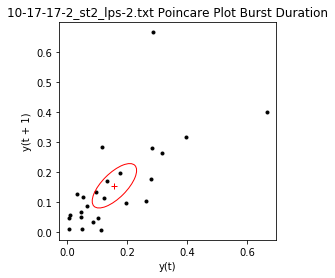

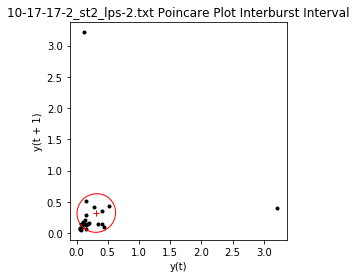

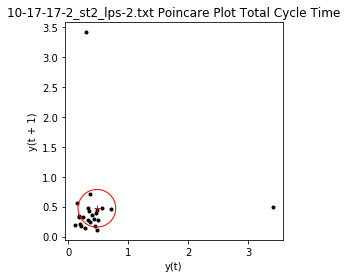

10-17-17-2_st2_lps-2.txt : complete


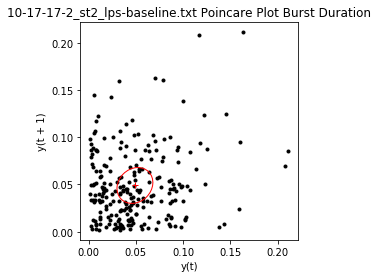

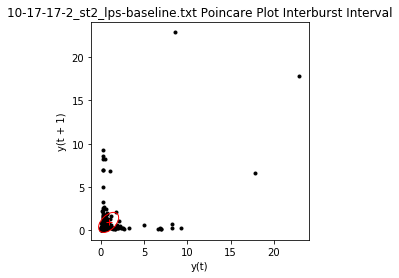

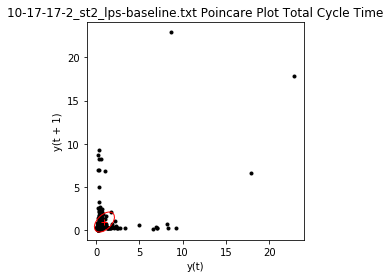

10-17-17-2_st2_lps-baseline.txt : complete


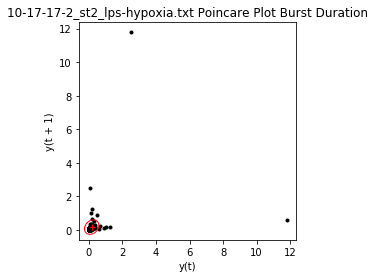

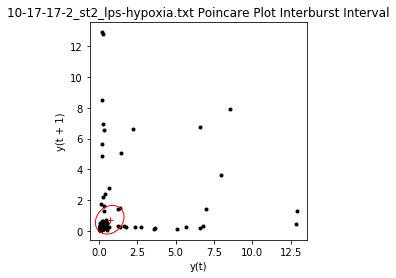

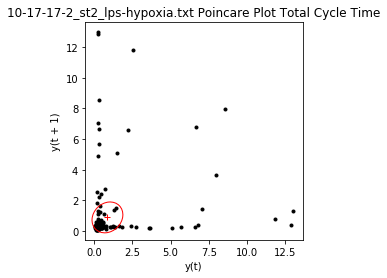

10-17-17-2_st2_lps-hypoxia.txt : complete


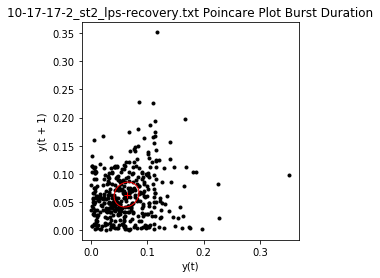

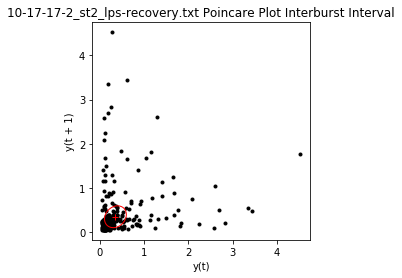

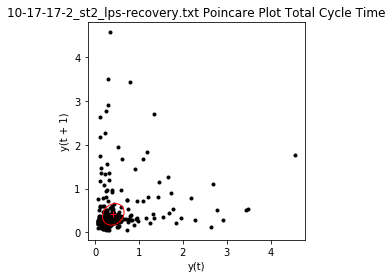

10-17-17-2_st2_lps-recovery.txt : complete


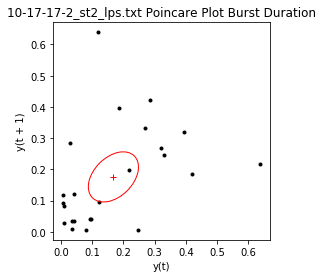

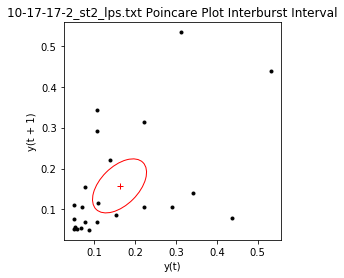

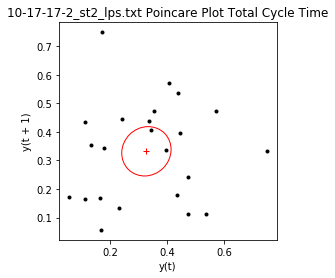

10-17-17-2_st2_lps.txt : complete


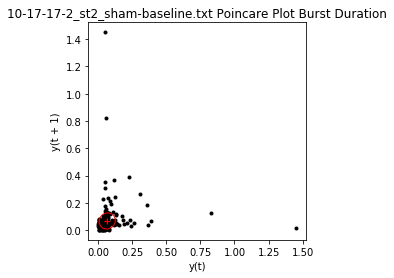

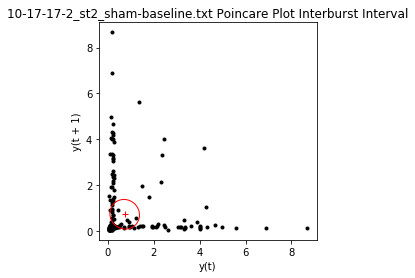

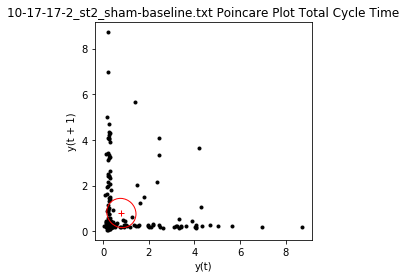

10-17-17-2_st2_sham-baseline.txt : complete


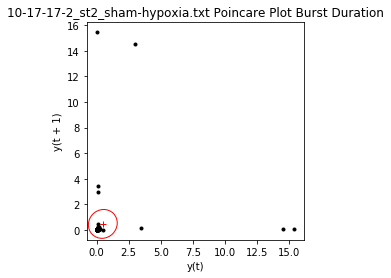

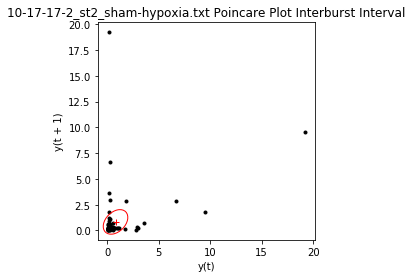

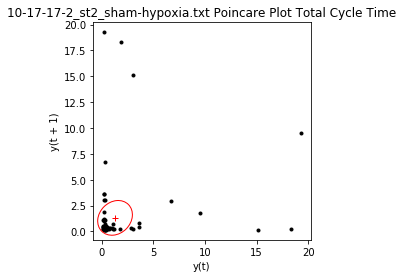

10-17-17-2_st2_sham-hypoxia.txt : complete


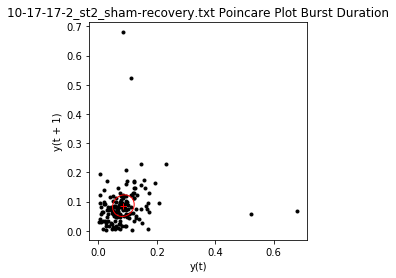

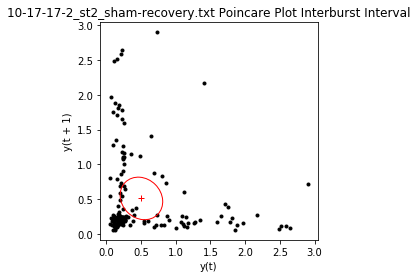

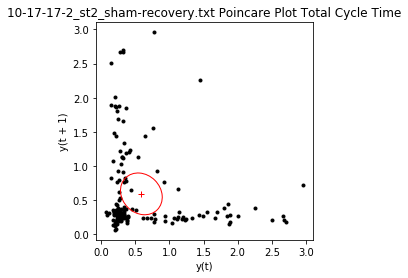

10-17-17-2_st2_sham-recovery.txt : complete


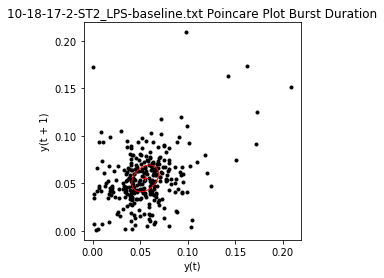

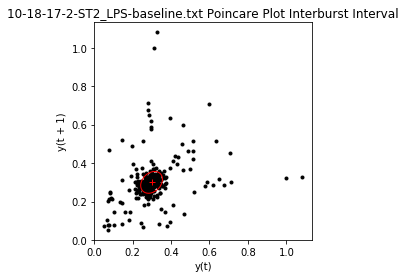

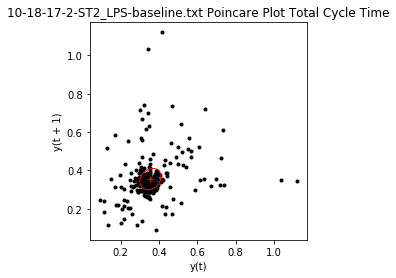

10-18-17-2-ST2_LPS-baseline.txt : complete


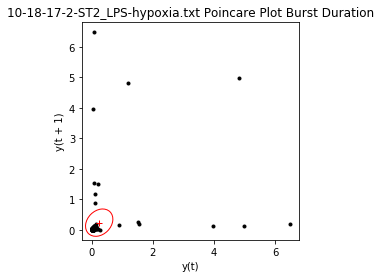

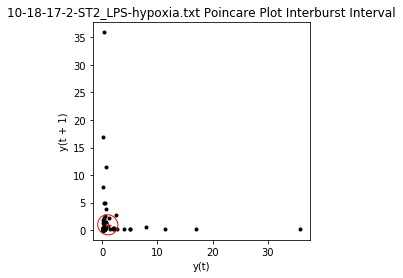

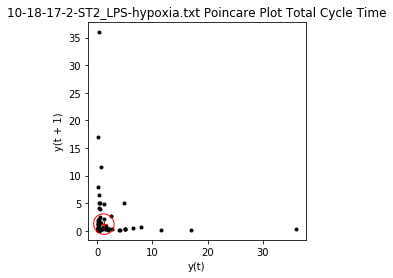

10-18-17-2-ST2_LPS-hypoxia.txt : complete


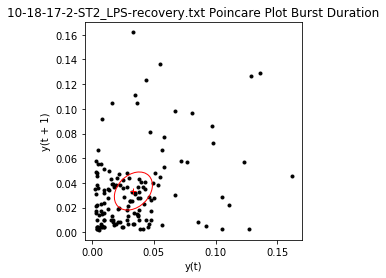

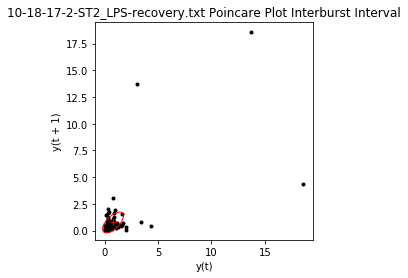

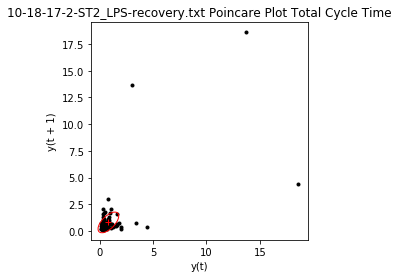

10-18-17-2-ST2_LPS-recovery.txt : complete


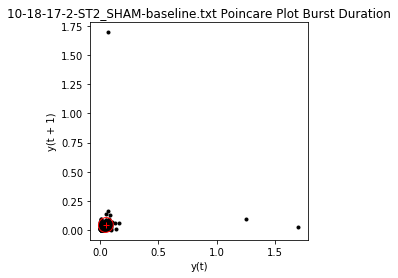

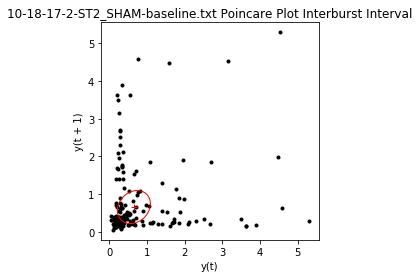

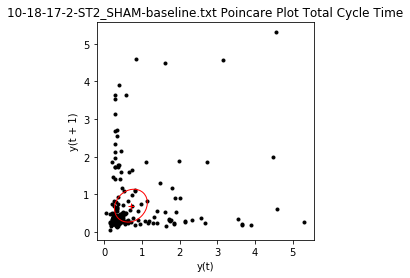

10-18-17-2-ST2_SHAM-baseline.txt : complete


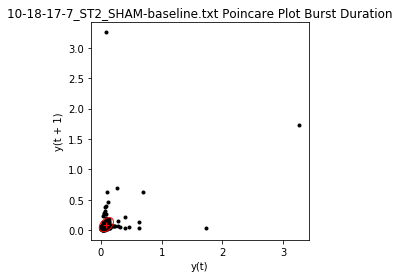

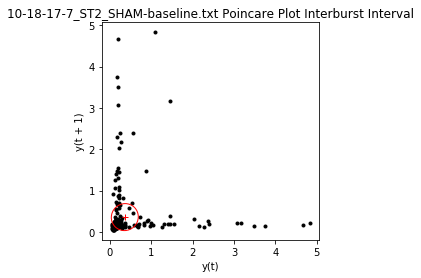

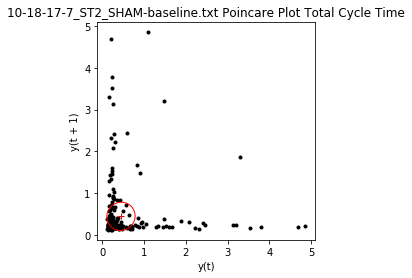

10-18-17-7_ST2_SHAM-baseline.txt : complete


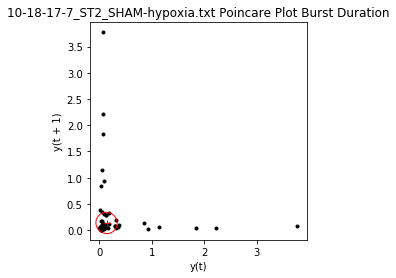

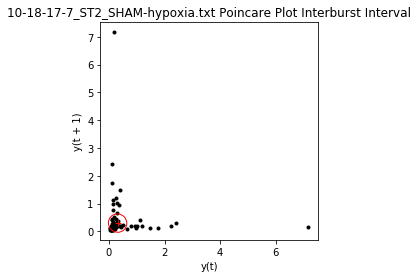

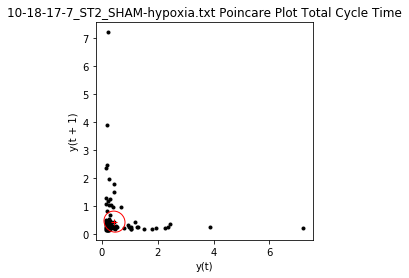

10-18-17-7_ST2_SHAM-hypoxia.txt : complete


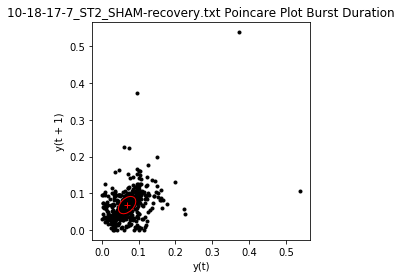

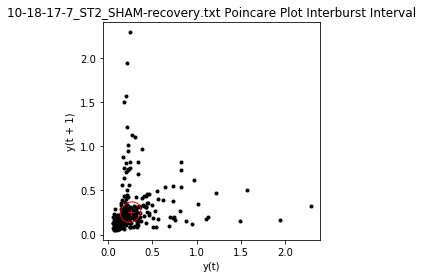

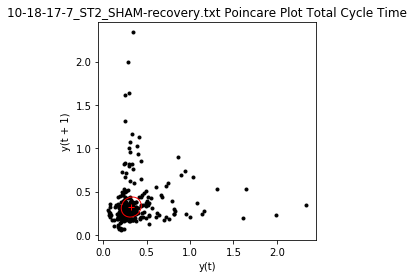

10-18-17-7_ST2_SHAM-recovery.txt : complete


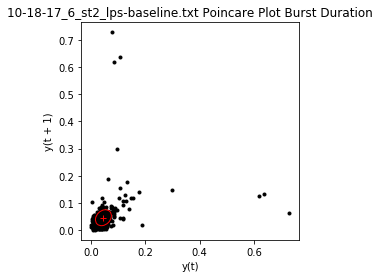

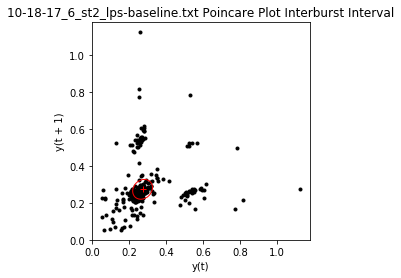

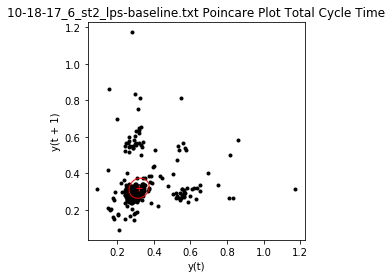

10-18-17_6_st2_lps-baseline.txt : complete


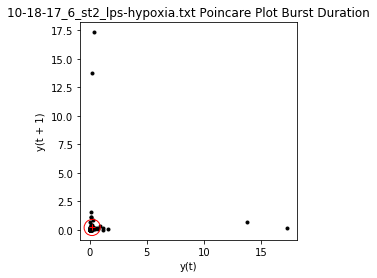

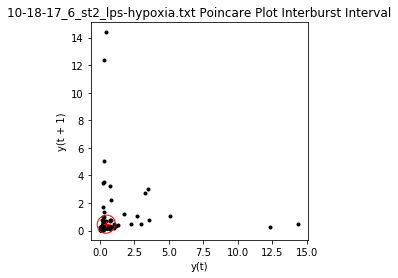

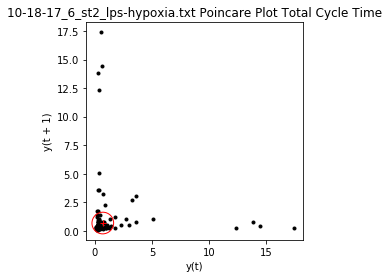

10-18-17_6_st2_lps-hypoxia.txt : complete


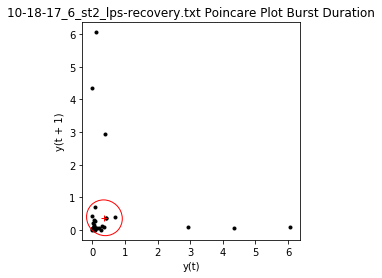

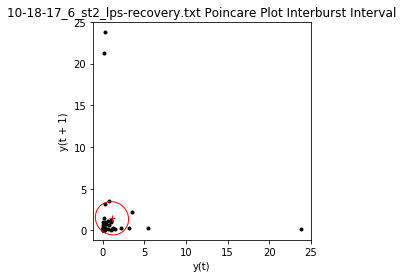

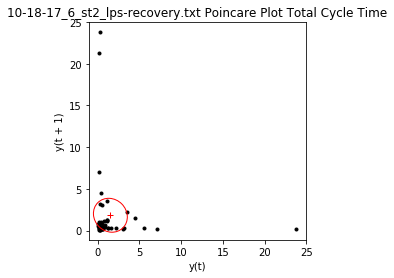

10-18-17_6_st2_lps-recovery.txt : complete


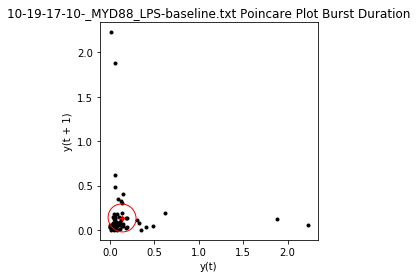

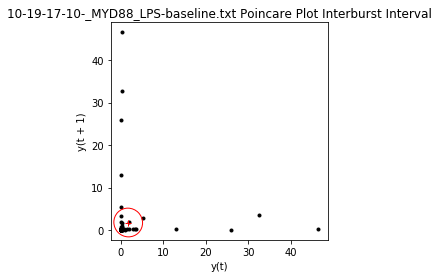

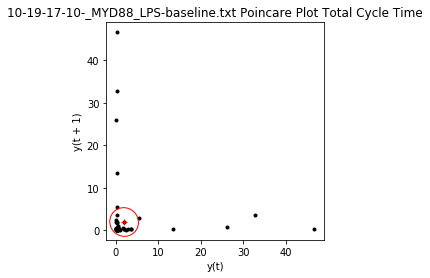

10-19-17-10-_MYD88_LPS-baseline.txt : complete


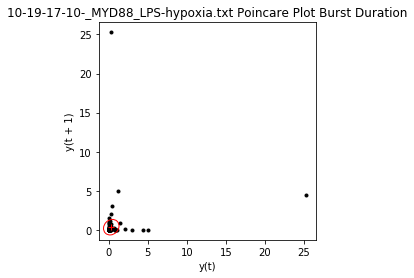

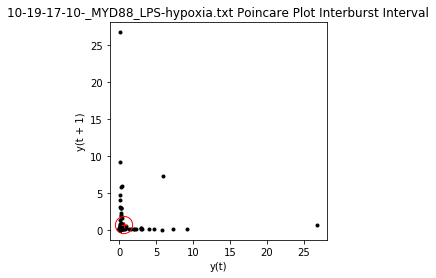

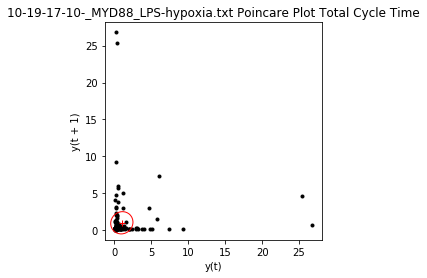

10-19-17-10-_MYD88_LPS-hypoxia.txt : complete


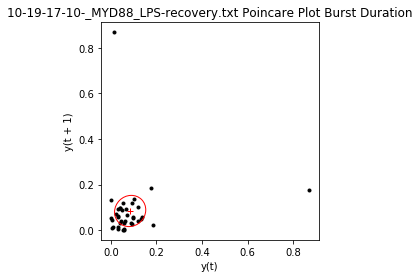

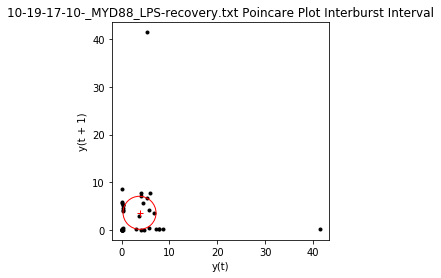

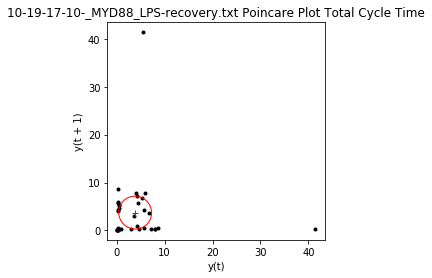

10-19-17-10-_MYD88_LPS-recovery.txt : complete


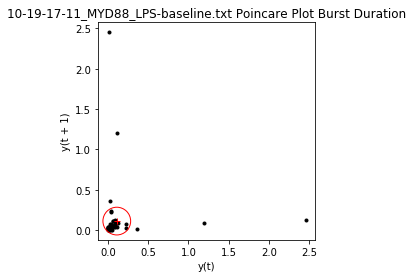

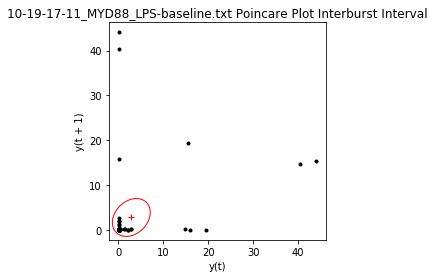

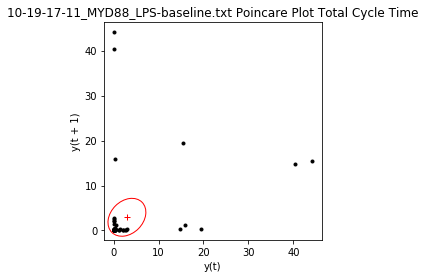

10-19-17-11_MYD88_LPS-baseline.txt : complete


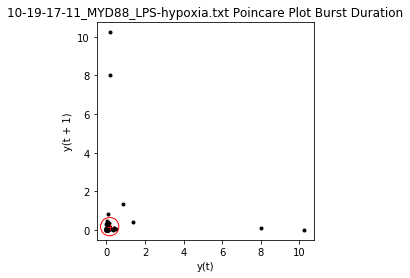

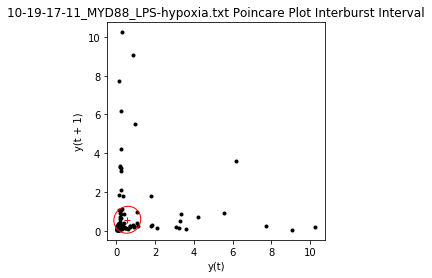

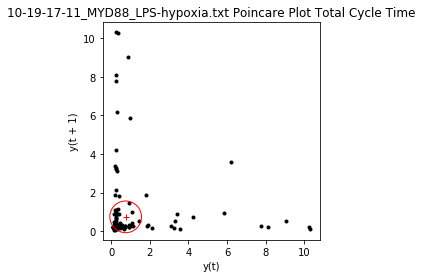

10-19-17-11_MYD88_LPS-hypoxia.txt : complete


C:\ProgramData\Anaconda2\lib\site-packages\pyentrp\entropy.py:139: RuntimeWarning: divide by zero encountered in log
  se = - np.log(similarity_ratio)


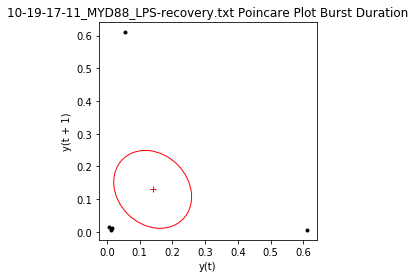

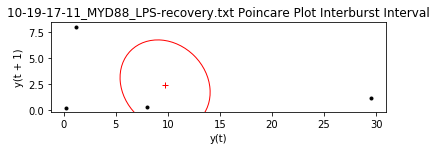

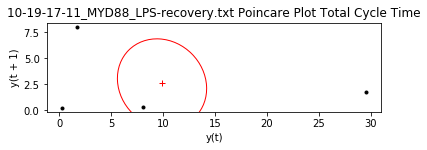

10-19-17-11_MYD88_LPS-recovery.txt : complete


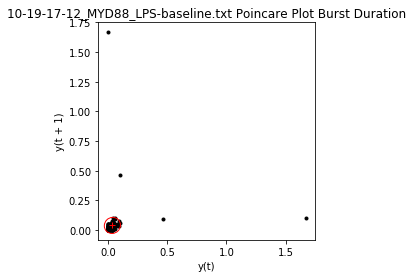

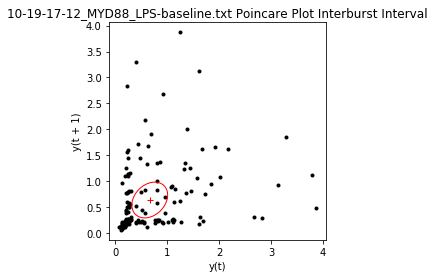

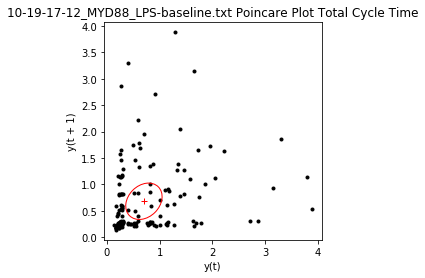

10-19-17-12_MYD88_LPS-baseline.txt : complete


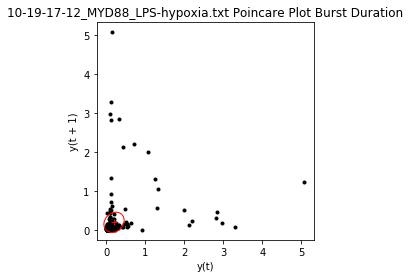

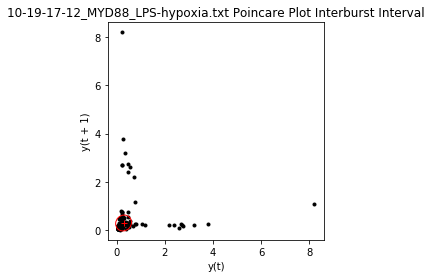

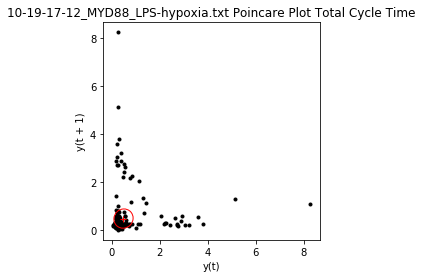

10-19-17-12_MYD88_LPS-hypoxia.txt : complete


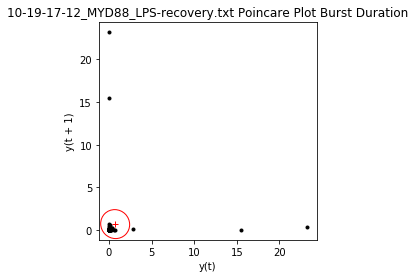

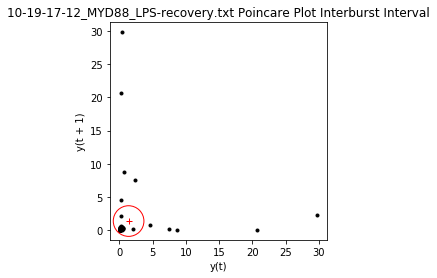

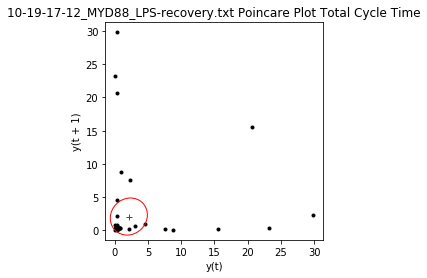

10-19-17-12_MYD88_LPS-recovery.txt : complete


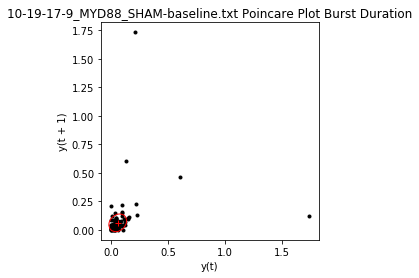

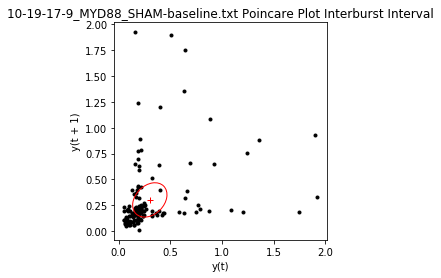

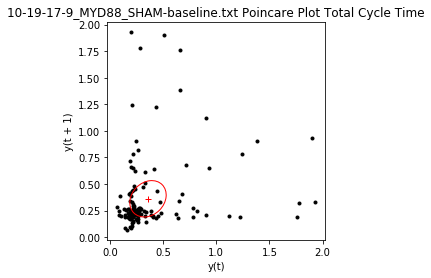

10-19-17-9_MYD88_SHAM-baseline.txt : complete


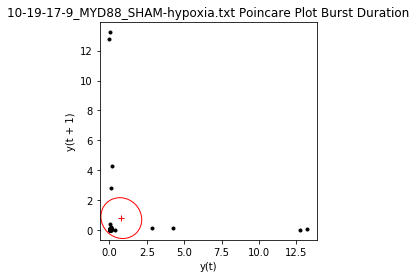

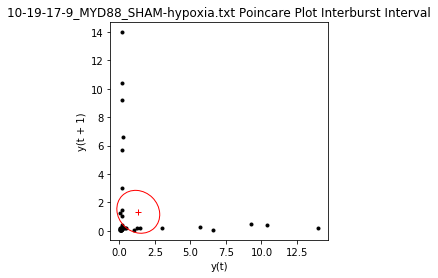

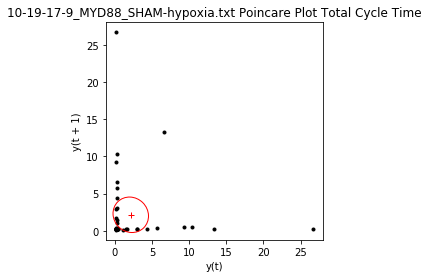

10-19-17-9_MYD88_SHAM-hypoxia.txt : complete


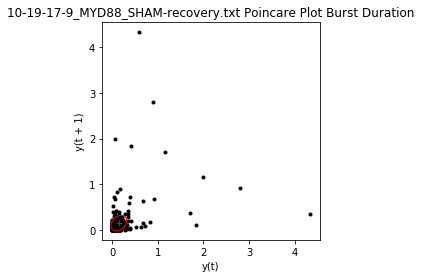

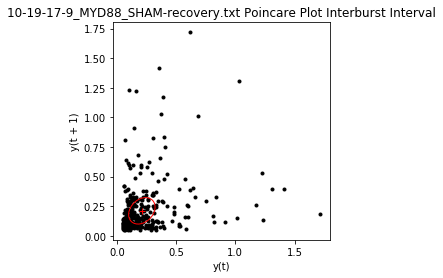

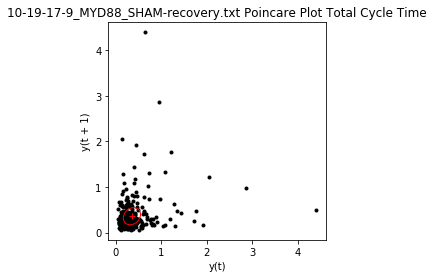

10-19-17-9_MYD88_SHAM-recovery.txt : complete


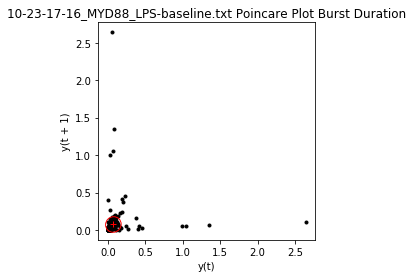

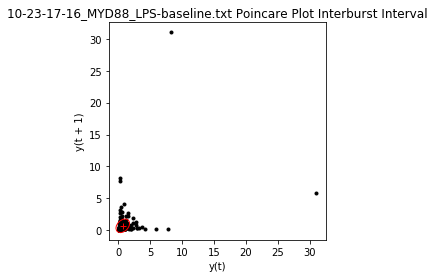

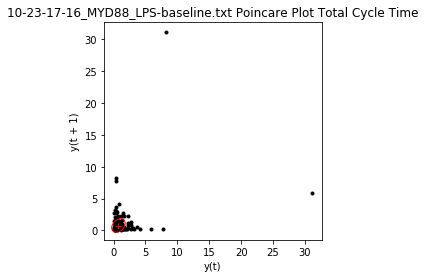

10-23-17-16_MYD88_LPS-baseline.txt : complete


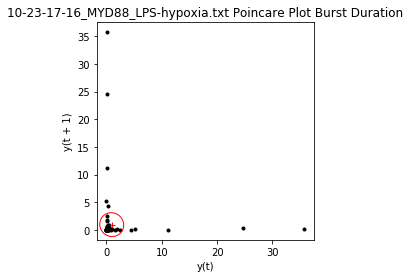

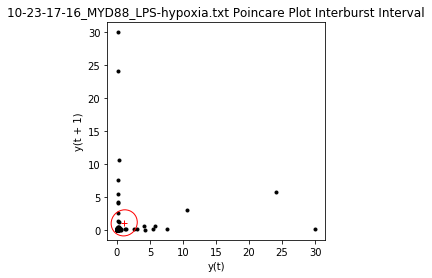

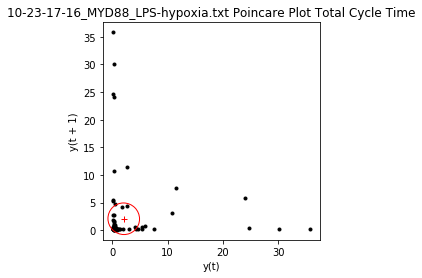

10-23-17-16_MYD88_LPS-hypoxia.txt : complete


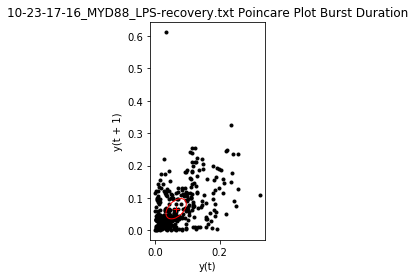

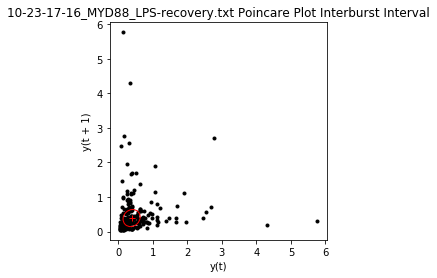

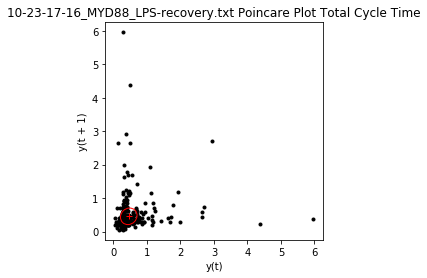

10-23-17-16_MYD88_LPS-recovery.txt : complete


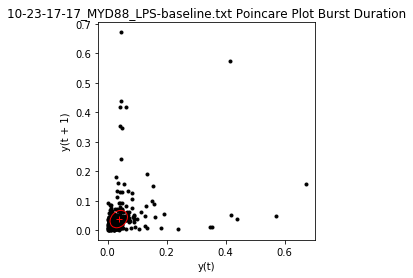

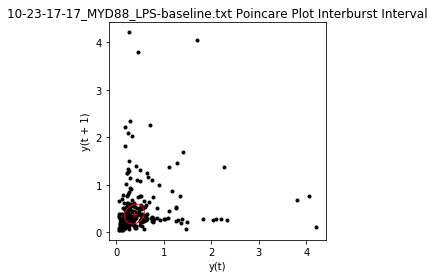

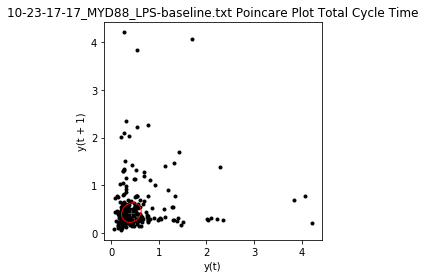

10-23-17-17_MYD88_LPS-baseline.txt : complete


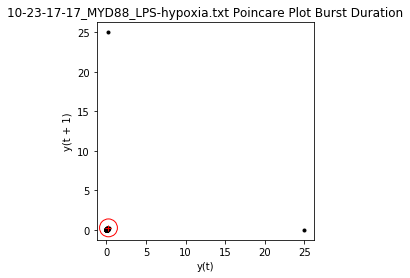

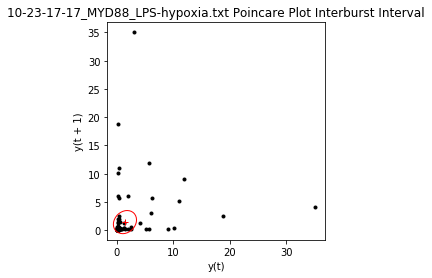

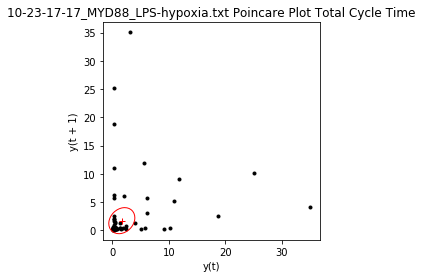

10-23-17-17_MYD88_LPS-hypoxia.txt : complete


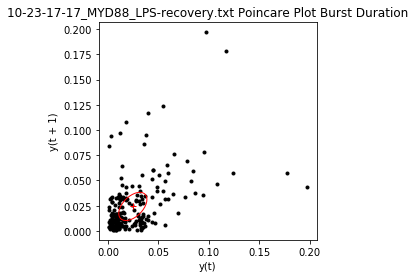

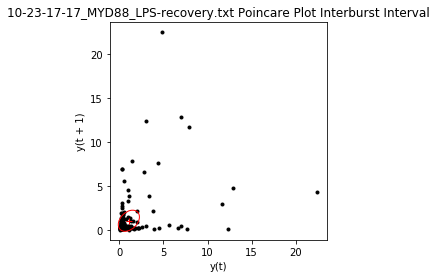

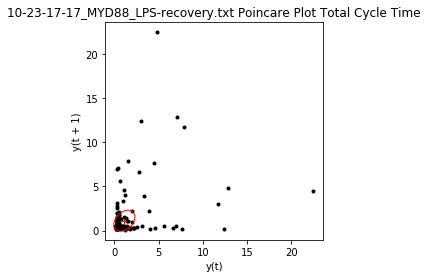

10-23-17-17_MYD88_LPS-recovery.txt : complete


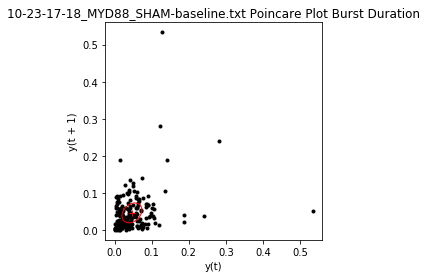

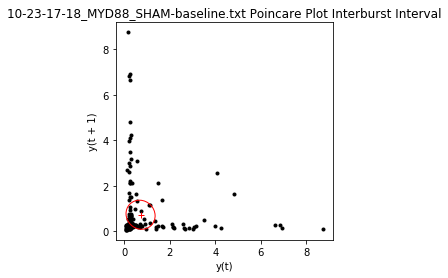

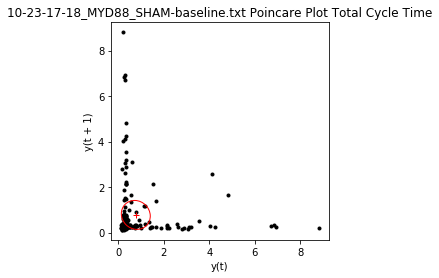

10-23-17-18_MYD88_SHAM-baseline.txt : complete


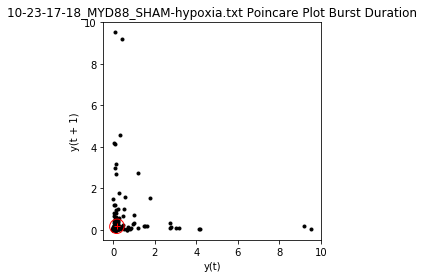

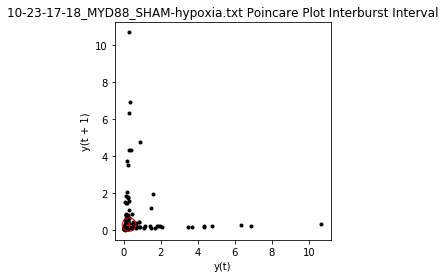

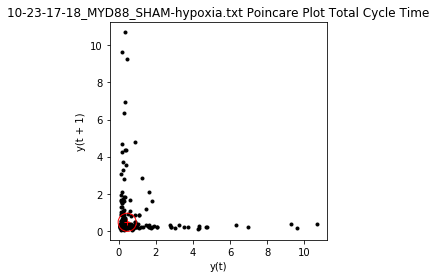

10-23-17-18_MYD88_SHAM-hypoxia.txt : complete


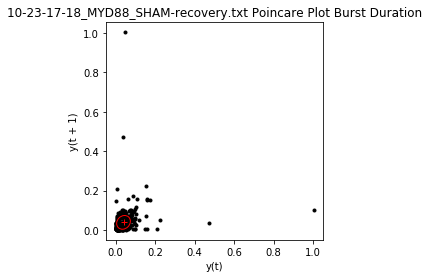

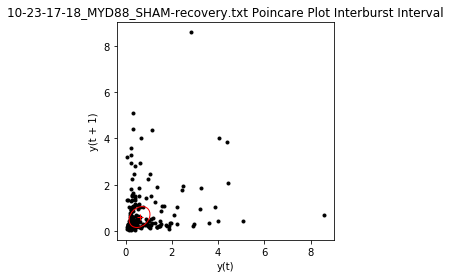

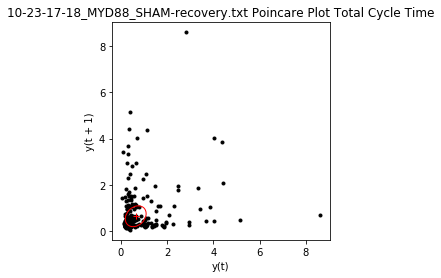

10-23-17-18_MYD88_SHAM-recovery.txt : complete


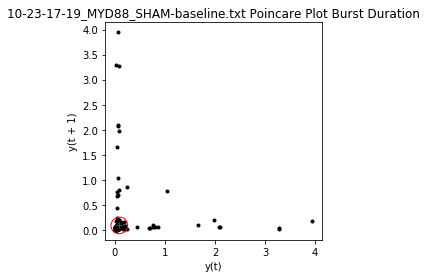

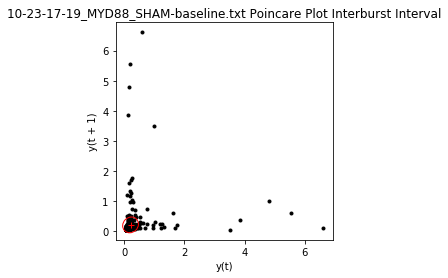

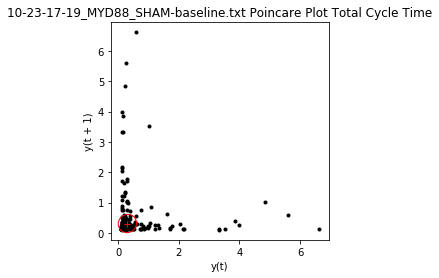

10-23-17-19_MYD88_SHAM-baseline.txt : complete


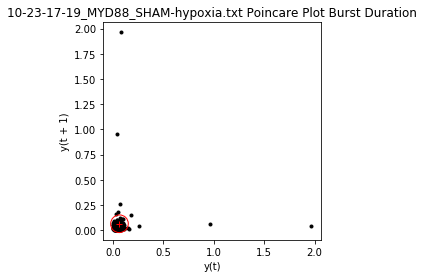

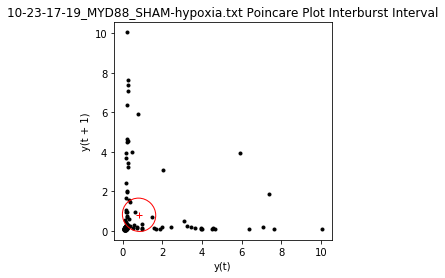

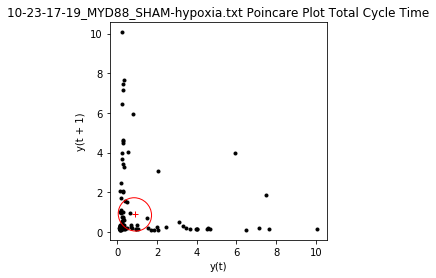

10-23-17-19_MYD88_SHAM-hypoxia.txt : complete


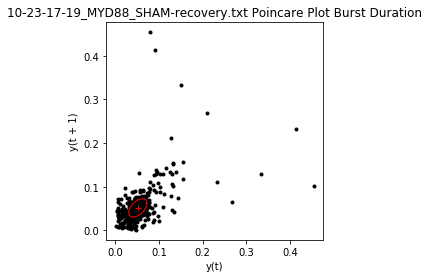

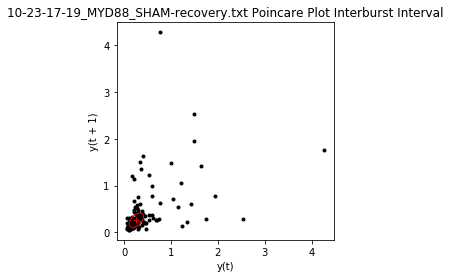

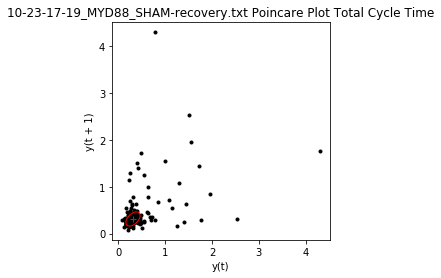

10-23-17-19_MYD88_SHAM-recovery.txt : complete


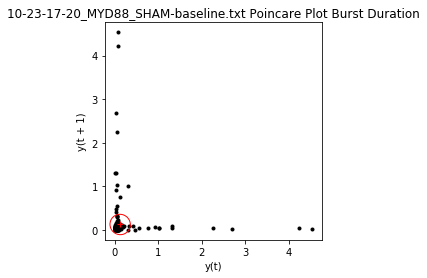

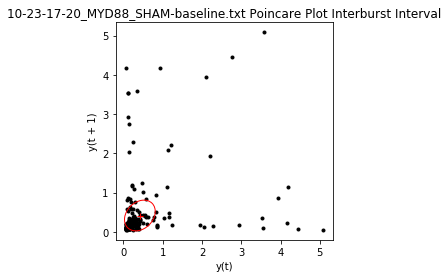

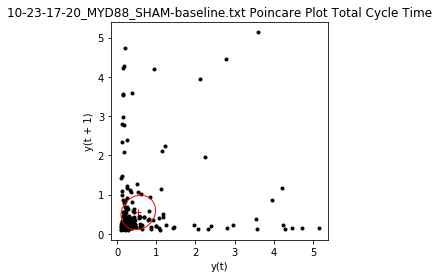

10-23-17-20_MYD88_SHAM-baseline.txt : complete


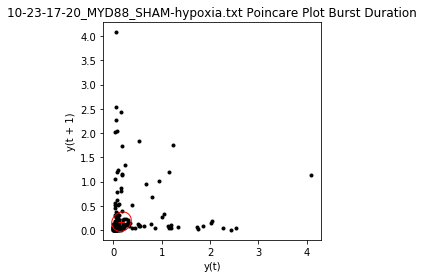

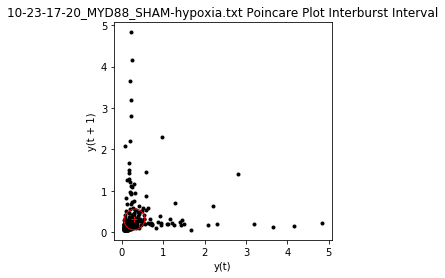

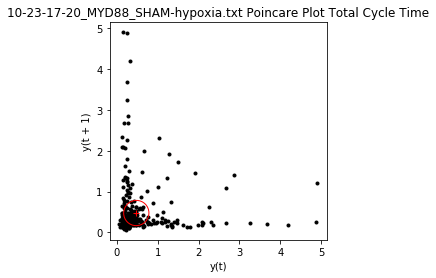

10-23-17-20_MYD88_SHAM-hypoxia.txt : complete


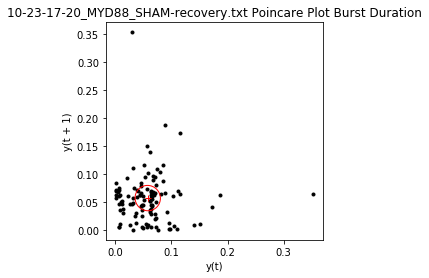

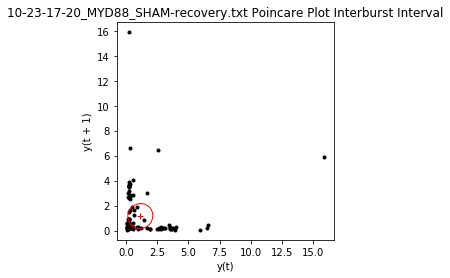

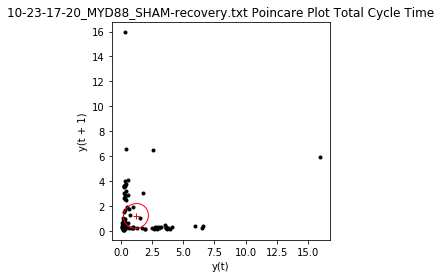

10-23-17-20_MYD88_SHAM-recovery.txt : complete


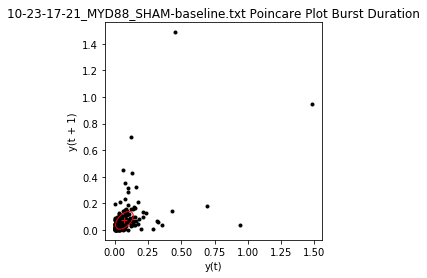

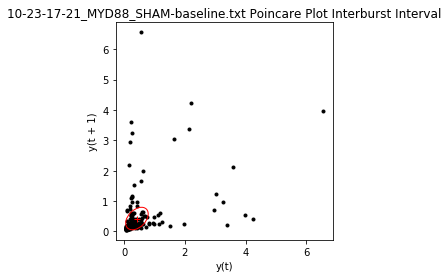

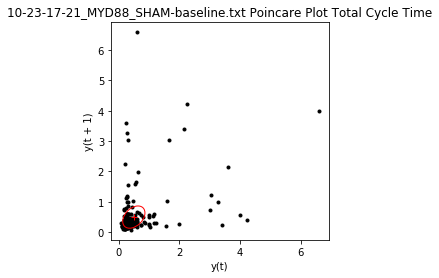

10-23-17-21_MYD88_SHAM-baseline.txt : complete


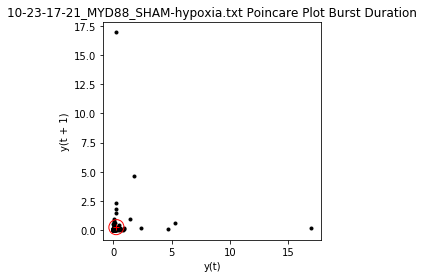

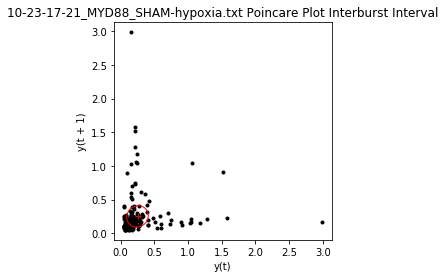

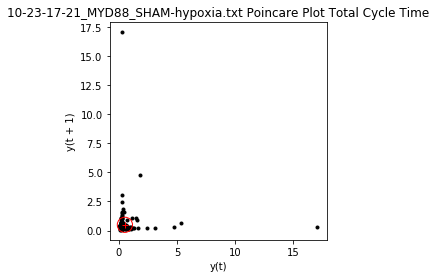

10-23-17-21_MYD88_SHAM-hypoxia.txt : complete


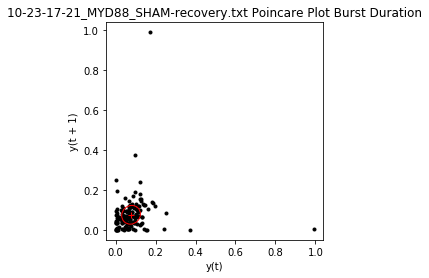

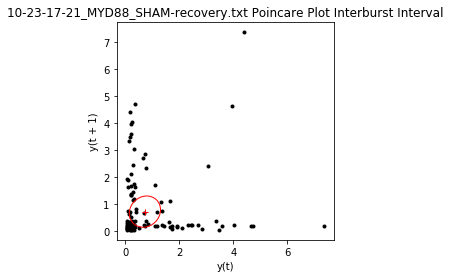

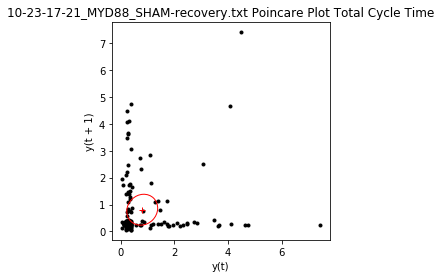

10-23-17-21_MYD88_SHAM-recovery.txt : complete


In [11]:
Results_lst = []

for i in  np.arange(len(filelst)): #taking out plt.show() breaks the ellipse drawing, so keeping it in for now
    Results_lst.append(run_and_analyze(filelst[i]))

In [12]:
df_results = pd.concat(Results_lst)
df_results

,Breaths,Recording Length (s),Mean Breath Rate,Minute Ventilation,AUC Mean,AUC Std,Insp Time Mean,Insp Time Std,Exp Time Mean,Exp Time Std,...,ShanEn TTotal,Poincare SD1 Burst Duration,Poincare SD2 Burst Duration,Poincare SD1/SD2 Burst Duration,Poincare SD1 Interburst Interval,Poincare SD2 Interburst Interval,Poincare SD1/SD2 Interburst Interval,Poincare SD1 Total Cycle Time,Poincare SD2 Total Cycle Time,Poincare SD1/SD2 Total Cycle Time
10-17-17-2_st2_lps-2.txt,26,13.239,117.833673,39.967231,0.048987,0.048008,0.158231,0.146377,0.310080,0.607058,...,4.643856,0.082092,0.192696,0.426015,0.610466,0.625525,0.975926,0.628003,0.629051,0.998335
10-17-17-2_st2_lps-baseline.txt,238,229.399,62.249617,11.230699,0.015000,0.012518,0.049046,0.037845,0.916869,2.314402,...,7.742098,0.034624,0.040946,0.845606,1.656988,2.830099,0.585488,1.651553,2.818960,0.585873
10-17-17-2_st2_lps-hypoxia.txt,198,179.599,66.147362,20.191064,0.076296,0.466388,0.167278,0.858242,0.727254,1.876343,...,7.441799,0.751328,0.957036,0.785057,1.670367,2.038932,0.819236,1.831464,2.182530,0.839147
10-17-17-2_st2_lps-recovery.txt,411,170.199,144.889218,27.093268,0.015337,0.011924,0.063438,0.044410,0.350815,0.493399,...,8.255545,0.040956,0.047185,0.867995,0.441185,0.540996,0.815506,0.444142,0.535910,0.828764
10-17-17-2_st2_lps.txt,25,11.519,130.219637,43.706885,0.049712,0.048976,0.169040,0.159175,0.160208,0.129734,...,4.584963,0.125116,0.189721,0.659473,0.093054,0.161879,0.574836,0.166385,0.179109,0.928956
10-17-17-2_st2_sham-baseline.txt,236,192.199,73.673640,47.584428,0.043615,0.092108,0.066572,0.118133,0.730843,1.288007,...,7.671135,0.114216,0.122386,0.933239,1.322363,1.257844,1.051294,1.323201,1.235954,1.070591
10-17-17-2_st2_sham-hypoxia.txt,90,119.699,45.113159,59.479032,0.616122,3.223601,0.469900,2.241490,0.818517,2.368709,...,6.354892,2.181149,2.323783,0.938620,1.897451,2.782036,0.682037,3.035928,3.652241,0.831251
10-17-17-2_st2_sham-recovery.txt,159,93.899,101.598526,24.093406,0.028279,0.026551,0.086063,0.074301,0.506481,0.611241,...,7.134446,0.069672,0.078282,0.890012,0.657432,0.565016,1.163563,0.658284,0.560567,1.174319
10-18-17-2-ST2_LPS-baseline.txt,301,106.519,169.547217,31.059540,0.008530,0.005033,0.055432,0.028358,0.299173,0.113397,...,7.638623,0.022939,0.032577,0.704152,0.095721,0.128342,0.745830,0.097952,0.123099,0.795716
10-18-17-2-ST2_LPS-hypoxia.txt,133,171.999,46.395619,19.564120,0.156378,0.633569,0.238361,0.891760,0.973265,3.642063,...,6.699623,0.772764,1.002302,0.770989,3.711999,3.597801,1.031741,3.787651,3.638353,1.041035


In [13]:
df_results.to_csv('pleth_batch_data_export.csv')